# Sexual Harassment Detection
Sexual harassment detection model implemented using Transfer Learning method - VGG16

## Importing necessary modules
### Data Processing and Manipulation
cv2 : Used for image processing tasks<br>
glob : Used to find file paths matching a pattern<br>
os : Used for interacting with the operating system<br>
numpy : Used for numerical computations and array handling<br>
pandas : Used for data manipulation and analysis<br>
### For Visualization
matplotlib.pyplot : Used for plotting graphs and images<br>
tqdm : Used to display progress bars during iterations<br>
### For Building ML model
keras : High-level neural networks API for building and training models<br>
tensorflow : Deep Learning framework used as backend for Keras<br>
sklearn : Library for machine learning tasks, such as model evaluation


In [1]:
import cv2
from glob import glob
from scipy import stats as s
import keras
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
import tensorflow.keras.applications.xception
from keras.applications.xception import Xception
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import keras.utils as image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint

### Reading a CSV file
This csv file contains two columns which has the location of the images in our dataset and the class label (0-Healthy Environment / 1-Harassment Detected) associated with it.

The csv file - 'harassment_as_csv.csv' is generated as an output of 'preprocessing.ipynb'
#### Loading 
Reads the csv file using pandas and stores it in the 'train' DataFrame.

In [2]:
train = pd.read_csv('harrasment_as_csv.csv') 
train.head() #displays the first five rows of the DataFrame

,image,class
0,images/harassment_yes\Screenshot 2023-07-22 01...,1
1,images/harassment_yes\Screenshot 2023-07-22 01...,1
2,images/harassment_yes\Screenshot 2023-07-22 01...,1
3,images/harassment_yes\Screenshot 2023-07-22 01...,1
4,images/harassment_yes\Screenshot 2023-07-22 01...,1


## Preprocessing Images 
This iterates through each row of the 'train' DataFrame, loads the image specified by the 'image' column.
#### Preprocessing Steps:
The image is resized to (224,224,3)

Converts it to a NumPy array.

Normalizes the pixel values to the range [0,1]

These processed images are then stored in the 'train_image' list.
This list is then converted to a NumPy array 'X'

In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img(train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255.0
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
x = np.array(train_image)

# shape of the array
x.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.91it/s]


(1000, 224, 224, 3)

#### Separating Target
Extracts the 'class' column from the 'train' DataFrame, which contains the class labels of the images.

In [4]:
# separating the target
y = train['class']
    

#### Dataset Segregation
The train_test_split function splits the 'x' and 'y' into training and testing parts.
The split is done with test size of 20% .

The 'stratify' parameter ensures that the class distribution is preserved in both the sets.

In [5]:
# creating the training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, stratify = y)

The fuction 'get_dummies' converts the categorical class labels into one-hot encoded format.

In [6]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## Loading our Pre-trained Model
A pre-trained VGG16 model is loaded from keras with pre-trained weights on the ImageNet dataset.
The fully connected layers at the top of the network is excluded by setting the parameter 'include_top' to False

In [7]:
# creating the base model of pre-trained VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights='imagenet', include_top=False)

### Extracting Features
Here we extract features from the images in the training and testing sets using our base_model - VGG16.
The 'predict' method is applied to both sets to obtain feature vectors for each image.

In [8]:
#extracting features for training frames
x_train = base_model.predict(x_train)
x_train.shape

25/25 [==============================] - 68s 3s/step


(800, 7, 7, 512)

In [9]:
# extracting features for validation frames
x_test = base_model.predict(x_test)
x_test.shape

7/7 [==============================] - 17s 2s/step


(200, 7, 7, 512)

The extracted features are reshaped into a format suitable for feeding into the subsequent fully connected layers. This depends on the architecture of the VGG16 model.

In [10]:
# reshaping the training as well as validation frames in single dimension
x_train = x_train.reshape(800, 7*7*512)
x_test = x_test.reshape(200, 7*7*512)

The feature vectors are normalized by dividing them by the maximum value of the training set.

In [11]:
# normalizing the pixel values
max = x_train.max()
x_train = x_train/max
x_test = x_test/max

## Model Architecture
Fully Connected(Dense) layers with ReLU activation function.

Dropout Layers for regularization.

Dense Layer with softmax activation for classification.

In [19]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#### Callback Definition 
A callback to save the model weights during training. It is saved in the 'weight.hdf5' file whenever the validation loss improves.

In [20]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#### Model compilation
The model is compiled with a categorical cross-entropy loss function, Adam optimizer, and accuracy metric. 

In [21]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

## Graphs, Plots and Visualization

### Sample Images
Plot of few sample images from the dataset along with their class labels.

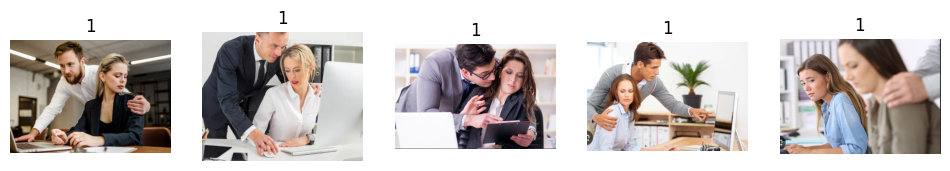

In [22]:
# Plot sample images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = load_img(train['image'][i])
    plt.imshow(img)
    plt.title(train['class'][i])
    plt.axis('off')
plt.show()

### Filters Evolution
This function is designed to visualize the evolution of filters in a specified layer of a given model.

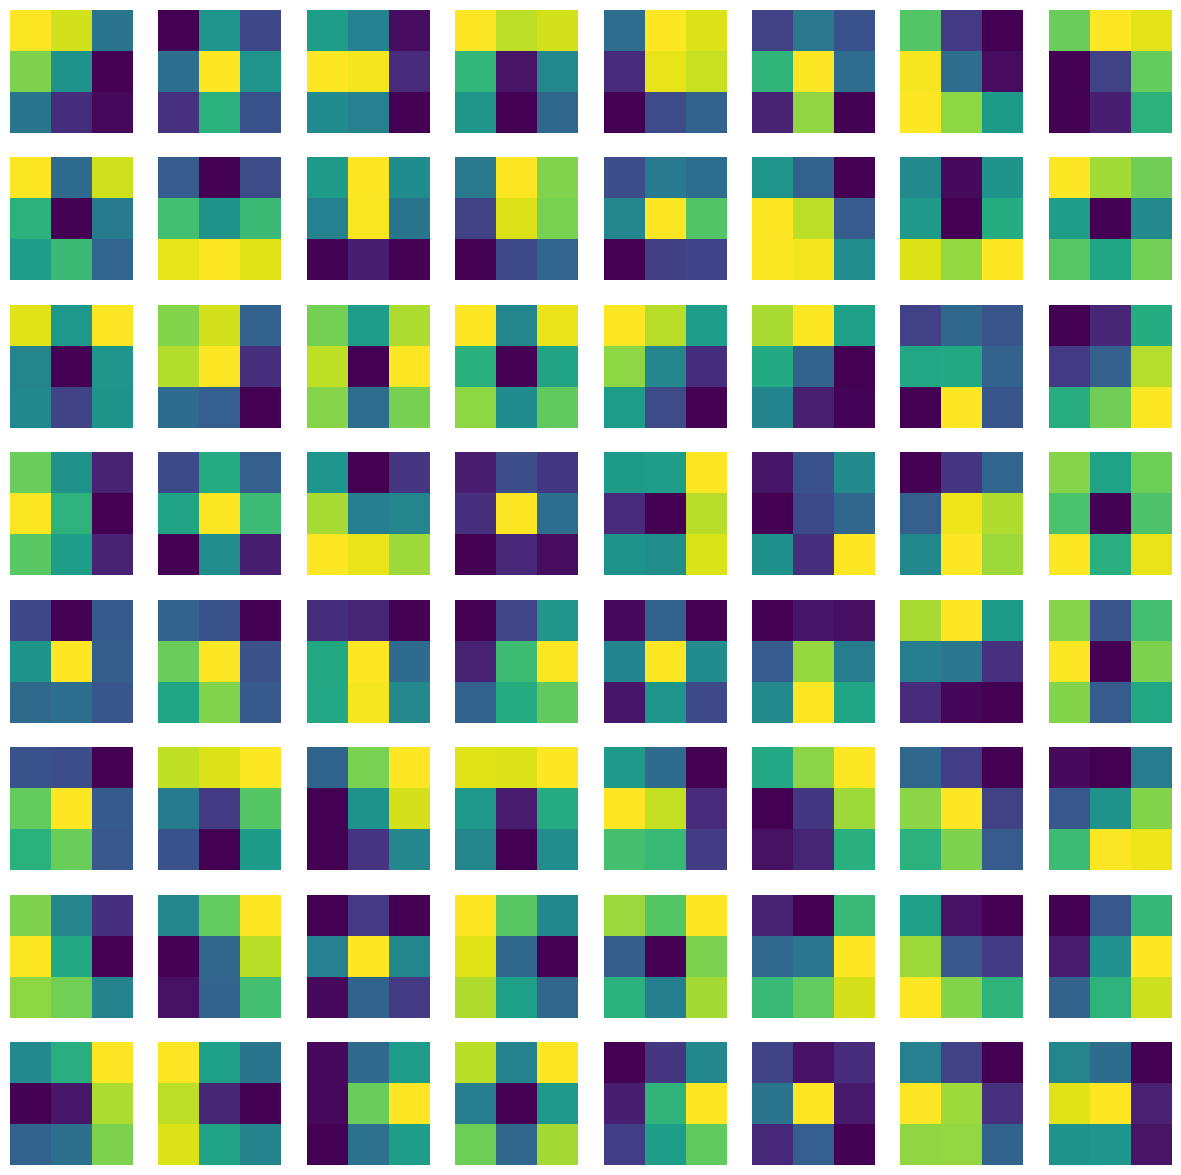

In [23]:
# Visualize filters in the first convolutional layer
filters = base_model.get_layer('block1_conv1').get_weights()[0]
plt.figure(figsize=(15, 15))
for i in range(filters.shape[-1]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters[:, :, 0, i], cmap='viridis')
    plt.axis('off')
plt.show()


### Class Distribution
To visualize the distribution of images between the classes.

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

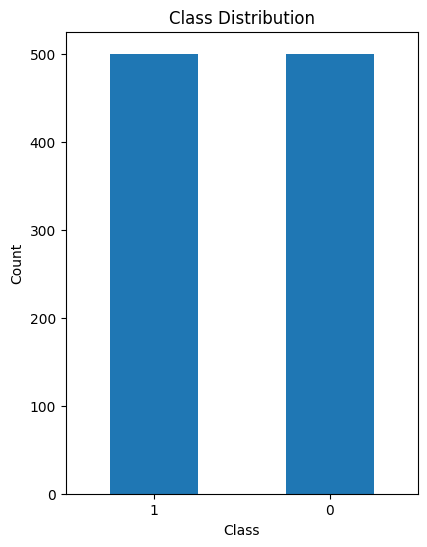

In [25]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
train['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')

plt.ylabel('Count')
plt.xticks(rotation=0)

### Visualizing Filter Evolution using an Image

1/1 [==============================] - 0s 88ms/step


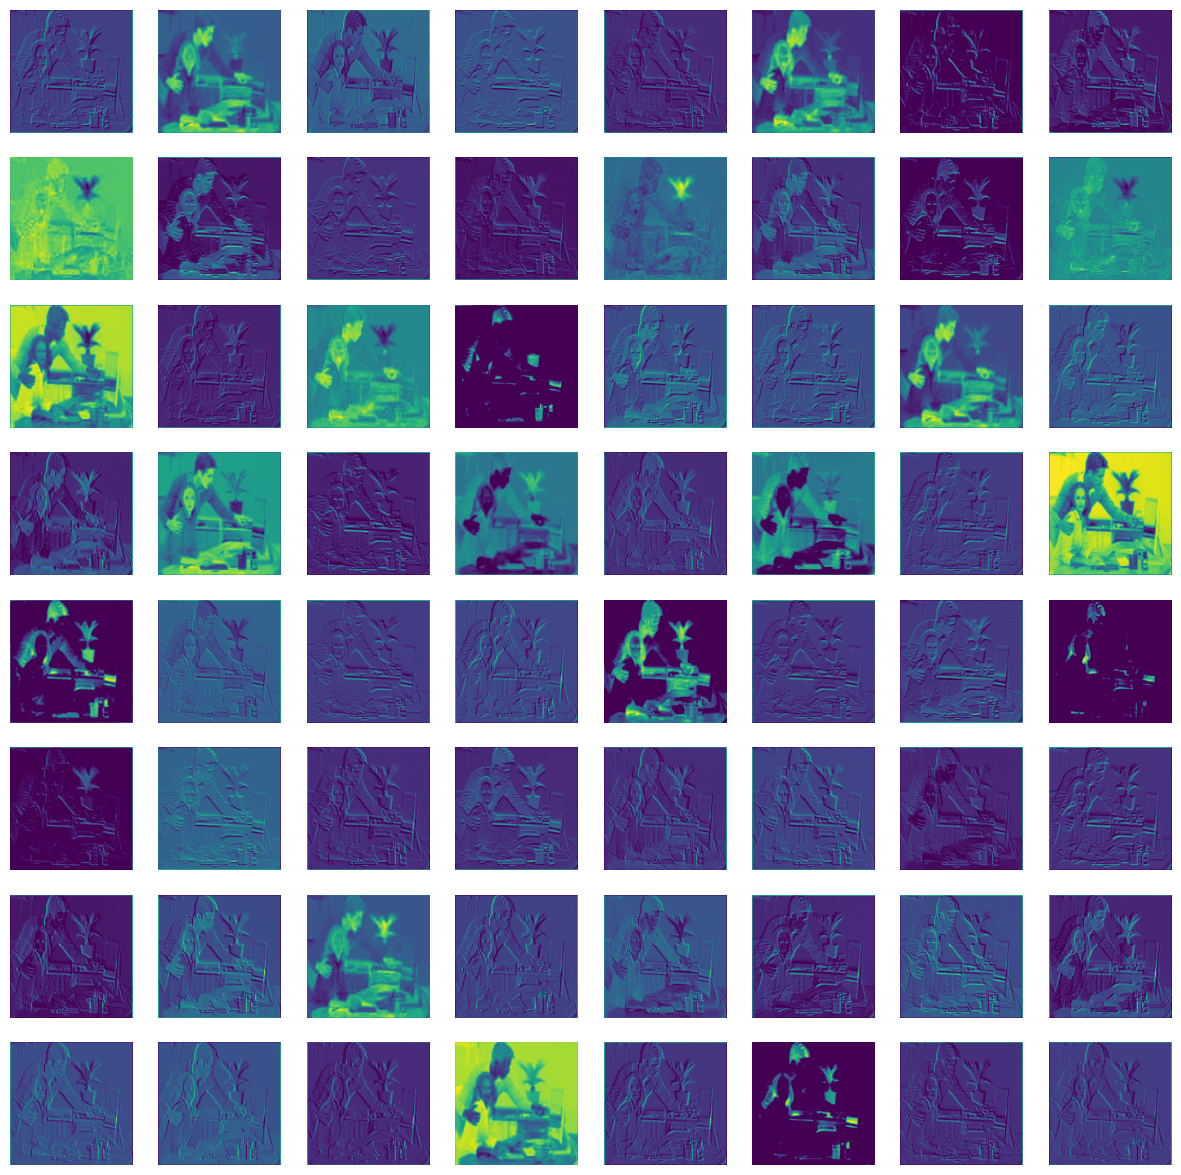

In [30]:
# Function to visualize filter evolution
img_path='test_images\s3.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.0
    
intermediate_layer_model = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv1').output)
intermediate_output = intermediate_layer_model.predict(img)
    
plt.figure(figsize=(15, 15))
for i in range(intermediate_output.shape[-1]):
    plt.subplot(8, 8, i+1)
    plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()


### t-SNE Visualization plot

In [33]:
# Function to visualize t-SNE embeddings
def visualize_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.Paired)
    plt.title("t-SNE Visualization")
    plt.show()

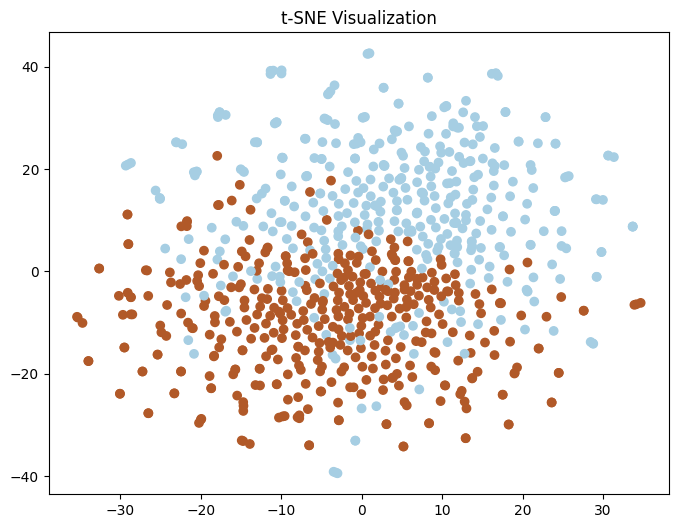

In [34]:
# Visualize t-SNE embeddings
visualize_tsne(x_train, y_train.values.argmax(axis=1))

## Training our Model
It trains on the training data while validating on the testing data. The training is performed for 200 epochs with a batch size of 128. The mcp_save callback is used to save the best weights during training.

In [36]:
# training the model
vgg_hist = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[mcp_save], batch_size=128)

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.5038

C:\Users\sudha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 5s 451ms/step - loss: 0.7659 - accuracy: 0.5038 - val_loss: 0.6048 - val_accuracy: 0.6900
Epoch 2/200
7/7 [==============================] - 3s 396ms/step - loss: 0.6972 - accuracy: 0.5962 - val_loss: 0.5226 - val_accuracy: 0.8100
Epoch 3/200
7/7 [==============================] - 3s 393ms/step - loss: 0.5431 - accuracy: 0.7225 - val_loss: 0.3301 - val_accuracy: 0.8950
Epoch 4/200
7/7 [==============================] - 3s 398ms/step - loss: 0.3801 - accuracy: 0.8363 - val_loss: 0.2565 - val_accuracy: 0.9150
Epoch 5/200
7/7 [==============================] - 2s 289ms/step - loss: 0.2616 - accuracy: 0.8838 - val_loss: 0.2734 - val_accuracy: 0.8800
Epoch 6/200
7/7 [==============================] - 2s 286ms/step - loss: 0.2221 - accuracy: 0.9125 - val_loss: 0.2639 - val_accuracy: 0.9200
Epoch 7/200
7/7 [==============================] - 2s 284ms/step - loss: 0.1527 - accuracy: 0.9388 - val_loss: 0.2680 - val_accuracy: 0.9050
Epoch 8/200
7/7 [========

### Visualizing Model Training History

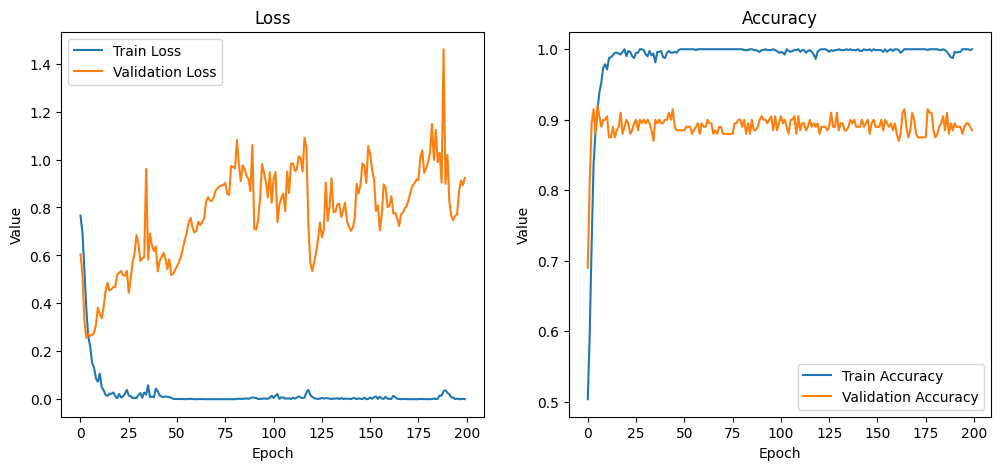

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_hist.history['loss'], label='Train Loss')
plt.plot(vgg_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_hist.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

### Confusion Matrix

7/7 [==============================] - 0s 27ms/step


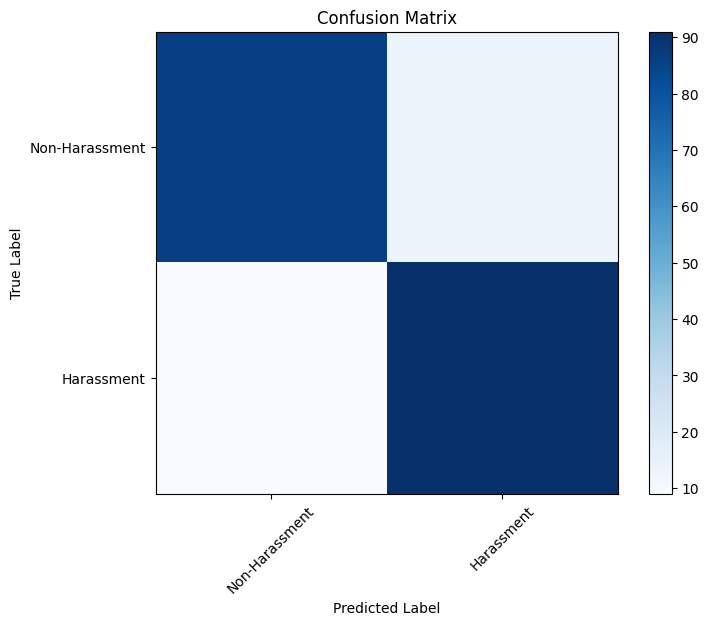

In [40]:
# Plot confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)
class_names = ['Non-Harassment', 'Harassment']
#plot_confusion_matrix(y_true, y_pred_classes, classes=class_names)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Evaluating the model's accuracy

In [39]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

7/7 [==============================] - 0s 26ms/step - loss: 0.9233 - accuracy: 0.8850
Test Accuracy: 88.49999904632568


# Predicting an Image input
The model detects whether the image contains any instance of Sexual Harassment and classifies the image into two class labels,

0 - Healthy Environment,
1 - Sexual Harassment detected

### Importing necessary modules


In [2]:
# Load the trained model
from keras.models import load_model
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


### Loading the saved model
The model saved as an output of 'Harassment_Detection_VGG16.ipynb' is loaded to make predictions.

In [3]:
model = load_model('weight.hdf5')  # Make sure you have the correct path to your saved model

### Preprocessing the input image
The image is preprocessed for prediction.It loads the image, resizes it, converts to a NumPy array, normalizes pixel values, and adds a batch dimension.

In [4]:
# Example usage
image_path = "test_images\s3.jpg"  # Replace with the path to any test image
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)  # Add batch dimension as the model expects it
new_image = img

Extracts features from the VGG16 base model for the new image and reshapes the features to match the input shape of the student model.

In [5]:
# Extract features using the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False)
new_image_features = base_model.predict(new_image)

# Reshape the features
new_image_features = new_image_features.reshape(1, 7*7*512)

1/1 [==============================] - 0s 170ms/step


### Making Predictions
The model uses the features extracted from VGG16 to make predictions.

In [6]:
# Make predictions
predictions = model.predict(new_image_features)

# Since your model has 2 output neurons (softmax), you can use argmax to get the predicted class index
predicted_class_index = np.argmax(predictions[0])


1/1 [==============================] - 0s 40ms/step


The predicted class index is determined, and the corresponding class label is retrieved using the class_labels dictionary

In [7]:
# If your classes are labeled as 0 and 1, you can map the index back to class labels
class_labels = {0: 'Healthy Environment', 1: 'Sexual Harassment Detected'}
predicted_class_label = class_labels[predicted_class_index]
#print(type(predicted_class_label))
print("Predicted Class Label:", predicted_class_label)


Predicted Class Label: Sexual Harassment Detected


# Predicting a video input
The model takes a video as input, extract frames from it and detects whether the image contains any instance of Sexual Harassment and classifies the image into two class labels,

0 - Healthy Environment<br>
1 - Sexual Harassment detected

### Importing necessary modules


In [8]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

### Loading the saved model
The model saved as an output of 'Harassment_Detection_VGG16.ipynb' is loaded to make predictions.

In [9]:
# Load the trained model
model = load_model(r'C:\SUDHARSHAN\Sexual_harassment_detection\weight.hdf5')  # Make sure you have the correct path to your saved model

### Loading our base model
This base model is pre-trained on the ImageNet dataset and is used to extract features from the video frames.

In [10]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False)

### Function to preprocess frames
Takes an input video frame and preprocesses it for feeding into the VGG16 base model.

In [11]:
# Preprocess a frame from the video
def preprocess_frame(frame):
    resized_frame = cv2.resize(frame, (224, 224))
    preprocessed_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)  # VGG16 expects RGB images
    preprocessed_frame = preprocess_input(preprocessed_frame)
    return preprocessed_frame

### Video input and Prediction

In [12]:
# Example usage
video_path = r"C:\SUDHARSHAN\Machine Learning\Application-of-Neural-Networks-for-Detection-of-Sexual-Harassment-in-Workspace-main\Application-of-Neural-Networks-for-Detection-of-Sexual-Harassment-in-Workspace-main\Dataset\Harassment\Harassment_h20.mp4"  # Replace with the path to your video file

cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Extract features using the VGG16 base model
    new_image_features = base_model.predict(np.expand_dims(preprocessed_frame, axis=0))
    new_image_features = new_image_features.reshape(1, 7 * 7 * 512)

    # Make predictions
    predictions = model.predict(new_image_features)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    # If your classes are labeled as 0 and 1, you can map the index back to class labels
    class_labels = {0: 'Healthy Environment', 1: 'Sexual Harassment Detected'}
    predicted_class_label = class_labels[predicted_class_index]

    # Display the predicted class label on the frame
    cv2.putText(frame, predicted_class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Video with Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 19ms/step


## Saving our Model for further usage

In [22]:
#saving our model
model.save('harrasment_model.h5')

C:\Users\sudha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite",'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\sudha\AppData\Local\Temp\tmpwa7e3lk3\assets


INFO:tensorflow:Assets written to: C:\Users\sudha\AppData\Local\Temp\tmpwa7e3lk3\assets
